# Mandelbrot Set - Mini Project - Stage 3

Numerical Scientific Computing (CE8-AVS) - Spring 2023 - Mini Project

**Author:** [Máté Tallósi](https://github.com/tallosim)
**Date:** 2023-04-26

In [1]:
import matplotlib.pyplot as plt
from dask import array as da
import numpy as np
import pyopencl as cl
import pandas as pd
import multiprocessing as mp
from numba import jit
import time
from tqdm import tqdm
import unittest

from utils import *

## Parameter Definition

The following parameters are used to define the Mandelbrot set. The parameters are defined in the following cell.

The resolution of the image is defined by the `X_RES` and `Y_RES` parameters. The `X_MIN`, `X_MAX`, `Y_MIN`, and `Y_MAX` parameters define the area of the complex plane that is displayed. The `I` parameter defines the maximum number of iterations for each pixel. The `T` parameter defines the threshold value for the Mandelbrot set.

In [2]:
X_RES = 5000
X_MIN = -2
X_MAX = 0.5
Y_RES = 5000
Y_MIN = -1.25
Y_MAX = 1.25

I = 50
T = 2

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Madelbrot Set Ploting

In [3]:
def make_plot(M, cmap='hot', save=False, filename='mandelbrot.png'):
    """
    Creates a plot of the Mandelbrot set from the input matrix M.

    Parameters:
    -----------
    M : numpy.ndarray
        The input matrix representing the Mandelbrot set.
    cmap : str or Colormap, optional
        The colormap used to plot the image. Defaults to 'hot'.
    save : bool, optional
        If True, saves the plot to a file with the given filename. Defaults to False.
    filename : str, optional
        The filename to save the plot to, if save is True. Defaults to 'mandelbrot.png'.

    Returns:
    --------
    None
    """
    
    plt.figure()
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.imshow(M, cmap=cmap, aspect='equal', extent=[X_MIN, X_MAX, Y_MIN, Y_MAX])

    if save:
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)

## Alreadey Implemented Calculation Methods

### Naive (loops) Implementation

In [4]:
def mandelbrot_naive(re, im, M, I, T):
    """
    Computes the Mandelbrot set using a naive algorithm.
    
    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
        
    Raises:
    -------
    ValueError
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            c = re[y] + im[x] * 1j
            z = 0 + 0j
            for i in range(I):
                z = z**2 + c
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Numpy (vectorized) Implementation

In [5]:
def mandelbrot_vectorized(re, im, M, I, T):
    """
    Computes the Mandelbrot set using a numpy vectorized algorithm.
    
    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
        
    Raises:
    -------
    ValueError
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    c = re + im[:, np.newaxis] * 1j
    z = np.zeros_like(c)
    mask = np.full_like(c, True, dtype=bool)

    for i in range(1, I+1):
        z[mask] = z[mask]**2 + c[mask]
        mask[T <= np.abs(z)] = False
        M[mask] = i / I

### Numba (optimized) Implementation

In [6]:
@jit(nopython=True)
def mandelbrot_numba(re, im, M, I, T):
    """
    Computes the Mandelbrot set using Numba's just-in-time (JIT) compilation.
    
    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
        
    Raises:
    -------
    ValueError
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            c = re[y] + im[x] * 1j
            z = 0 + 0j
            for i in range(I):
                z = z**2 + c
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Parallel (using multiprocessing) Implementation

In [7]:
@jit(nopython=True)
def mandelbrot_chunk(re, im, I, T):
    """
    Computes the Mandelbrot set using Numba's just-in-time (JIT) compilation in one chunk.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.

    Returns:
    --------
    numpy.ndarray
        A two-dimensional array used to store the result of the computation.
    """

    M = np.zeros((im.shape[0], re.shape[0]))
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if abs(z) > T:
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1
    
    return M

def mandelbrot_paralell(re, im, M, I, T, P=8, C=20):
    """
    Computes the Mandelbrot set using a parallel algorithm.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
    P : int, optional
        The number of processes used for parallel computation. Defaults to 8.
    C : int, optional
        The chunk size used to divide the input arrays into subarrays. Defaults to 20.

    Raises:
    -------
    ValueError:
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    pool = mp.Pool(processes=P)

    results = [pool.apply_async(mandelbrot_chunk, args=(re[i:i+C], im, I, T)) for i in range(0, re.shape[0], C)]

    pool.close()
    pool.join()
    
    M[:] = np.hstack([r.get() for r in results])

### Dask (distributed) Implementation

In [8]:
def mandelbrot_dask(re, im, M, I, T):
    """
    Compute the Mandelbrot set using Dask for parallel computation.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : np.ndarray
        A 2D array of floats to store the output of the computation.
    I : int
        The maximum number of iterations to use when computing the Mandelbrot set.
    T : float
        The threshold value for determining whether a point is part of the set.

    Raises:
    -------
    ValueError:
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    c = da.array(re + im[:, np.newaxis] * 1j)
    z = da.zeros_like(c)
    mask = da.full_like(c, True, dtype=bool)

    for i in range(1, I+1):
        z[mask] = z[mask]**2 + c[mask]
        mask[T <= da.abs(z)] = False
        M[mask] = i / I

## Unit Tests

Creating 3 unit tests to check the implemented mandelbrot set calculation methods.
- Test that the function raises a ValueError if the shape of the input arrays do not match
- Test that the output values are between 0 and 1.
- Test that the output values of the function are correct. The correctness is determined by an naive implementation of the Mandelbrot set.

In [9]:
class MandelbrotTest(unittest.TestCase):
    def setUp(self):
        self.x_res = 500
        self.y_res = 500
        self.mandelbrot_func = mandelbrot_vectorized
        self.accuracy = 5

    def test_parameters_value_errors(self):
        """
        Test that the function raises a ValueError if the shape of the input arrays do not match.
        """
        re = np.linspace(X_MIN, X_MAX, self.x_res)
        im = np.linspace(Y_MIN, Y_MAX,  self.y_res)
        M = np.zeros((self.x_res+1, self.y_res+1))
        
        with self.assertRaises(ValueError):
            self.mandelbrot_func(re, im, M, I, T)
        
    def test_output_values(self):
        """
        Test that the output values are between 0 and 1.
        """
        re = np.linspace(X_MIN, X_MAX, self.x_res)
        im = np.linspace(Y_MIN, Y_MAX, self.y_res)
        M = np.zeros((self.x_res, self.y_res))
        
        self.mandelbrot_func(re, im, M, I, T)
        
        self.assertTrue(np.all(M <= 1))
        self.assertTrue(np.all(M >= 0))
        
    def test_value_correctness(self):     
        """
        Test that the output values of the function are correct. The correctness is determined by an naive implementation of the Mandelbrot set.
        """   
        re = np.linspace(X_MIN, X_MAX, self.x_res)
        im = np.linspace(Y_MIN, Y_MAX, self.y_res)
        M = np.zeros((self.x_res, self.y_res))
        
        self.mandelbrot_func(re, im, M, I, T)
        
        for x in range(self.x_res):
            for y in range(self.y_res):
                c = re[y] + im[x] * 1j
                z = 0 + 0j
                for i in range(I):
                    z = z**2 + c
                    if abs(z) > T:
                        self.assertAlmostEqual(M[x, y], i / I, places=self.accuracy)
                        break
                else:
                    self.assertAlmostEqual(M[x, y], 1.0, places=self.accuracy)

In [10]:
print(f'Tested function: mandelbrot_vectorized')
unittest.main(argv=[''], verbosity=2, exit=False)   

test_output_values (__main__.MandelbrotTest)
Test that the output values are between 0 and 1. ... ok
test_parameters_value_errors (__main__.MandelbrotTest)
Test that the function raises a ValueError if the shape of the input arrays do not match. ... ok
test_value_correctness (__main__.MandelbrotTest)
Test that the output values of the function are correct. The correctness is determined by an naive implementation of the Mandelbrot set. ... 

Tested function: mandelbrot_vectorized


ok

----------------------------------------------------------------------
Ran 3 tests in 3.084s

OK


## OpenCL (GPU) Implementation

In [11]:
print_opencl_devices()
ctx = cl.create_some_context()

OpenCL Platforms and Devices
Platform - Name:  Apple
Platform - Vendor:  Apple
Platform - Version:  OpenCL 1.2 (Mar  4 2023 12:44:59)
Platform - Profile:  FULL_PROFILE
    --------------------------------------------------------
    Device - Name:  Apple M1
    Device - Type:  ALL | GPU
    Device - Max Clock Speed:  1000 Mhz
    Device - Compute Units:  8
    Device - Local Memory:  32 KB
    Device - Constant Memory:  1048576 KB
    Device - Global Memory: 11 GB
    Device - Max Buffer/Image Size: 2048 MB
    Device - Max Work Group Size: 256


In [12]:
def mandelbrot_opencl(re, im, M, I, T):
    global ctx
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')

    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    c = re + im[:, np.newaxis] * 1j
    c_flat = np.ravel(c).astype(np.complex64)
    
    M_flat = np.ravel(M).astype(np.float32)
    
    c_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=c_flat)
    M_buf = cl.Buffer(ctx, mf.WRITE_ONLY, M_flat.nbytes)

    with open('mandelbrot.cl', 'r') as f:
        mandelbrot_kernel_source = f.read()
    
    prg = cl.Program(ctx, mandelbrot_kernel_source).build()
    prg.mandelbrot_kernel(queue, M_flat.shape, None, c_buf, M_buf, np.uint16(I), np.float32(T))

    cl.enqueue_copy(queue, M_flat, M_buf).wait()
    
    M[:] = M_flat.reshape(M.shape)

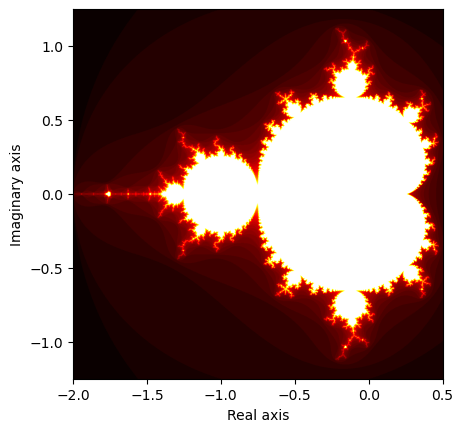

In [13]:
re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES)
M = np.zeros((X_RES, Y_RES))

mandelbrot_opencl(re, im, M, I, T)

make_plot(M)